<a href="https://colab.research.google.com/github/ejnunn/GAN-Research/blob/main/SPAGAN_Faces_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [7]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and Utils

## Library Imports

In [8]:
import torch
from torch import nn
from tqdm.auto import tqdm # progress bars
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # visualizations
import pandas as pd # data processing
import shutil # file management
import torch.nn.functional as F # used in Hyperparameters cell
from skimage import color
import numpy as np

torch.manual_seed(0)

## Helper functions

In [9]:
# Compute the number of trainable parameters
def total_trainable_parameters(models):
  total = sum([len(x.parameters()) for x in models])
  return total

In [10]:
# Visualize images in a 2x2 grid.
# real_A | real_B
# fake_A | fake_B
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [11]:
# Save backup model weights to Google Drive account.
def save_model_to_drive(filename, drive_dir):
  try:
    # Copy latest checkpoint to Drive for permenant storage
    save_filename = drive_dir + filename
    torch.save({
      'gen_AB': gen_AB.state_dict(),
      'gen_BA': gen_BA.state_dict(),
      'gen_opt': gen_opt.state_dict(),
      'disc_A': disc_A.state_dict(),
      'disc_A_opt': disc_A_opt.state_dict(),
      'disc_B': disc_B.state_dict(),
      'disc_B_opt': disc_B_opt.state_dict()
    }, f"{save_filename}.pth")
  except:
    print('Need to mount a Google Drive account to runtime.')

# ImageDataset Class

In [12]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

# Inspired by https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/datasets.py
class ImageDataset(Dataset):
    '''
    Parameters:
    max_size - limit dataset size to ensure effective epoch training duration
    '''
    def __init__(self, root, transform=None, mode='train', max_size=10000):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))[:max_size]
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))[:max_size]
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the correct images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))

        # Convert B&W images into RGB color
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

# Network architecture

## ResidualBlock Class

In [13]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class:
    Performs two convolutions and an instance normalization, the input is added
    to this output to form the residual block output.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ResidualBlock: 
        Given an image tensor, completes a residual block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

## ContractingBlock Class

In [14]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs a convolution followed by a max pool operation and an optional instance norm.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs a convolutional transpose operation in order to upsample, 
        with an optional instance norm
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x



## FeatureMapBlock Class

In [15]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a Generator - 
    maps each the output to the desired number of output channels
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

## Generator Class

In [16]:
class Generator(nn.Module):
    '''
    Generator Class
    A series of 2 contracting blocks, 9 residual blocks, and 2 expanding blocks to 
    transform an input image into an image from the other class, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        '''
        Function for completing a forward pass of Generator: 
        Given an image tensor, passes it through the U-Net with residual blocks
        and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## Discriminator Class

In [17]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

## Loss Functions

### Get Discriminator Loss

In [18]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the target labels and returns a adversarial 
            loss (which you aim to minimize)
    '''

    fake_X.detach()
    fake_pred = disc_X(fake_X)
    fake_loss = adv_criterion(fake_pred, torch.zeros_like(fake_pred))
    real_pred = disc_X(real_X)
    real_loss = adv_criterion(real_pred, torch.ones_like(real_pred))
    disc_loss = (fake_loss + real_loss) / 2.0

    return disc_loss

### Get Generator Adversarial Loss

In [19]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Return the adversarial loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images 
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the target labels and returns a adversarial 
                  loss (which you aim to minimize)
    '''

    fake_Y = gen_XY(real_X)
    pred_Y = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(pred_Y, torch.ones_like(pred_Y))

    return adversarial_loss, fake_Y

### Get Identity Loss

In [20]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Return the identity loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        identity_criterion: the identity loss function; takes the real images from X and
                        those images put through a Y->X generator and returns the identity 
                        loss (which you aim to minimize)
    '''

    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(real_X, identity_X)

    return identity_loss, identity_X

### Get Cycle Consistency Loss

In [21]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Return the cycle consistency loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''

    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X

### Get Generator Loss

In [22]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        real_A: the real images from pile A
        real_B: the real images from pile B
        gen_AB: the generator for class A to B; takes images and returns the images 
            transformed to class B
        gen_BA: the generator for class B to A; takes images and returns the images 
            transformed to class A
        disc_A: the discriminator for class A; takes images and returns real/fake class A
            prediction matrices
        disc_B: the discriminator for class B; takes images and returns real/fake class B
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the true labels and returns a adversarial 
            loss (which you aim to minimize)
        identity_criterion: the reconstruction loss function used for identity loss
            and cycle consistency loss; takes two sets of images and returns
            their pixel differences (which you aim to minimize)
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
            those images put through a X->Y generator and then Y->X generator
            and returns the cycle consistency loss (which you aim to minimize).
            Note that in practice, cycle_criterion == identity_criterion == L1 loss
        lambda_identity: the weight of the identity loss
        lambda_cycle: the weight of the cycle-consistency loss
    '''

    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adv_loss,fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    adv_loss_2,fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    
    # Identity Loss -- get_identity_loss(real_X, gen_YX, identity_criterion)
    ide_loss,identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    ide_loss_2,identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)

    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cyc_loss,cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cyc_loss_2,cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    # Total loss
    
    gen_loss = adv_loss + adv_loss_2 + lambda_identity * (ide_loss + ide_loss_2) +  lambda_cycle * (cyc_loss + cyc_loss_2)

    return gen_loss, fake_A, fake_B

### Criterion

In [23]:
## Criterion for adversarial loss and reconstruction loss
adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss()

# Training

## Hyperparameters

In [24]:
# Default model to accept RGB images
# B&W images will be broadcast to 3 dims
dim_A = 3
dim_B = 3

In [25]:
# Model Arch hyperparameters
batch_size = 1
lr = 0.0002
load_shape = 128 # originally 286. Why?
target_shape = 128 # originally 256

# GPU Acceleration, use 'cpu' if no GPU is available
device = 'cuda'

## Define model and load weights

In [26]:
# File Management and model weights filename
pretrained = True

In [28]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
if pretrained:
    model_dir = 'drive/MyDrive/GAN Research/CycleGAN/models/smile/'
    # Get most recent file based on days of training
    list_of_files = glob.glob(model_dir + "*") # * means all if need specific format then *.csv
    latest_checkpoint = max(list_of_files, key=os.path.getctime)
    print('loading {}'.format(latest_checkpoint))
    model_name = os.path.splitext(os.path.basename(latest_checkpoint))[0]

    pre_dict = torch.load(latest_checkpoint)
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])

    print('latest_checkpoint loaded successfully!')

else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)

    print('random weights initialized.')

loading drive/MyDrive/GAN Research/CycleGAN/models/smile/smile_80_25_30_15.pth
latest_checkpoint loaded successfully!


## Load data

In [29]:
assert False

AssertionError: ignored

### Load CelebA Dataset

In [33]:
## Create two groups of image files, smiling and not smiling ##

# Create dataframe to sort CelebA images
img_dir_celeba = '/content/drive/MyDrive/GAN Research/CycleGAN/CycleGAN Images/CelebA/'
attr_filename = 'list_attr_celeba.txt'

df = pd.read_csv(img_dir_celeba + attr_filename, skiprows=1, delim_whitespace=True)
df = df.reset_index()
df.rename(columns={'index': 'filename'}, inplace=True)

# Lists of smiling and non-smiling image filenames
smiling_list = list(df[['filename']].loc[df['Smiling'] == 1]['filename'])
not_smiling_list = list(df[['filename']].loc[df['Smiling'] == -1]['filename'])

In [35]:
## Unzip images and move files into the correct category ##

# Unzip images from drive and store in current directory
!unzip -q /content/drive/MyDrive/GAN\ Research/CycleGAN/CycleGAN\ Images/CelebA/img_align_celeba.zip

# Create training A and B subdirectories
!mkdir img_align_celeba/trainA
!mkdir img_align_celeba/trainB

# Move images into correct subdirectory
source_dir = 'img_align_celeba/'
destination_dir = 'img_align_celeba/trainA'
for img in smiling_list:
  shutil.move(source_dir + img, destination_dir)

source_dir = 'img_align_celeba/'
destination_dir = 'img_align_celeba/trainB'
for img in not_smiling_list:
  shutil.move(source_dir + img, destination_dir)
print('images loaded successfully!')

images loaded successfully!


In [36]:
## Load files into a Image Dataset object ##

# Apply transforms to dataset to augment
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

img_dir = 'img_align_celeba'
training_max_images = 2000
dataset = ImageDataset(img_dir, transform=transform, max_size=training_max_images)

print("Size of dataset: {} images".format(len(dataset)))

Size of dataset: 2000 images


## Train model

In [37]:
## Training session length and console output debugging ##

# Training epochs
n_epochs = 50

# Visualizations
display_step = 100

# Save to Google Drive
save_epoch = 5

## Start training

Epoch 0: Step 0: Generator (U-Net) loss: 0.026148486137390136, Discriminator loss: 0.0007619204372167587


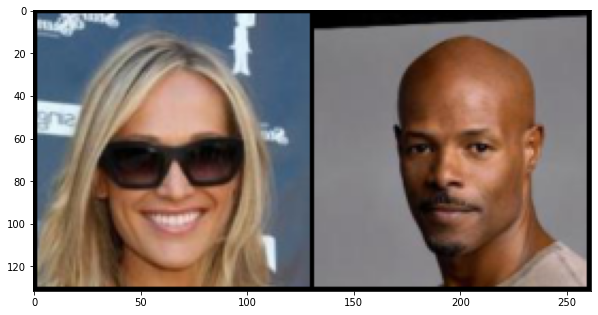

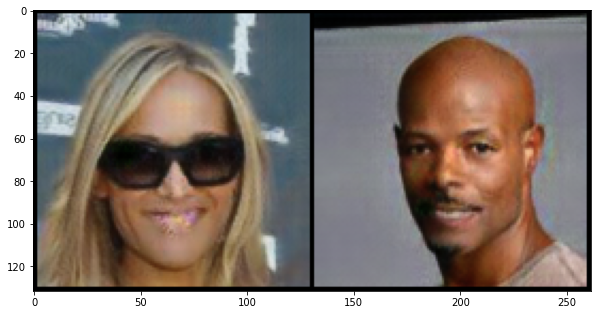

Epoch 0: Step 100: Generator (U-Net) loss: 2.3518655562400825, Discriminator loss: 0.1352042263001203


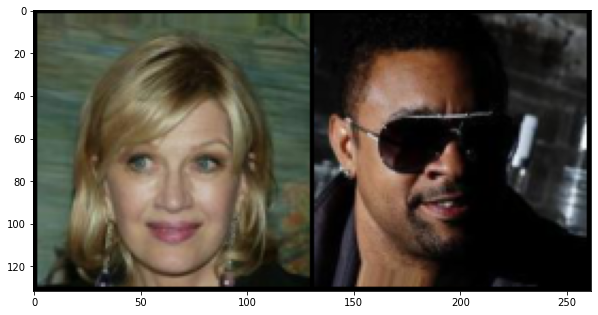

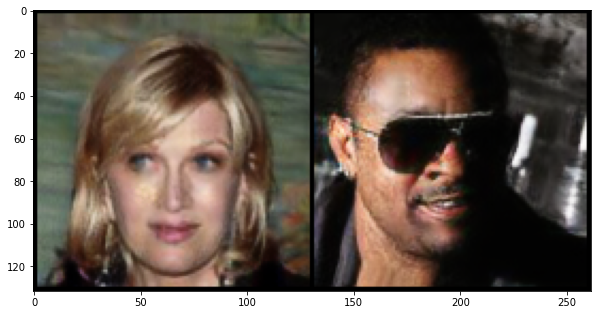

Epoch 0: Step 200: Generator (U-Net) loss: 2.2909892904758467, Discriminator loss: 0.13758534111082557


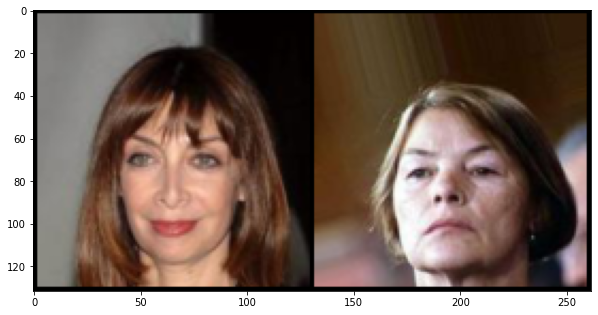

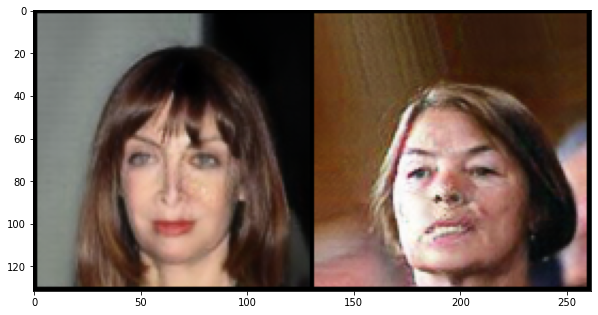

Epoch 0: Step 300: Generator (U-Net) loss: 2.371336644887925, Discriminator loss: 0.14820876725018023


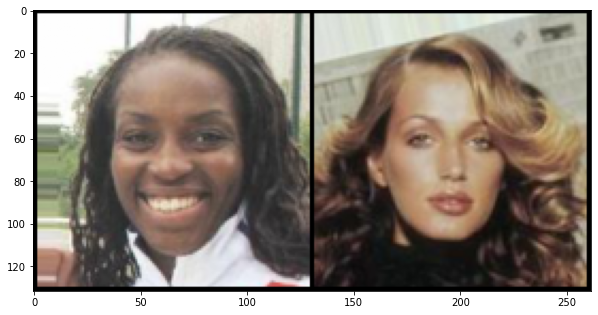

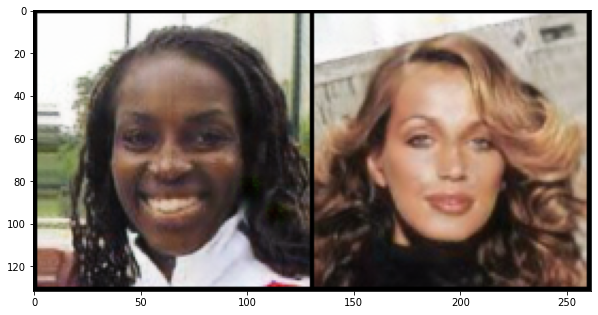

Epoch 0: Step 400: Generator (U-Net) loss: 2.3894917047023774, Discriminator loss: 0.1302827532589436


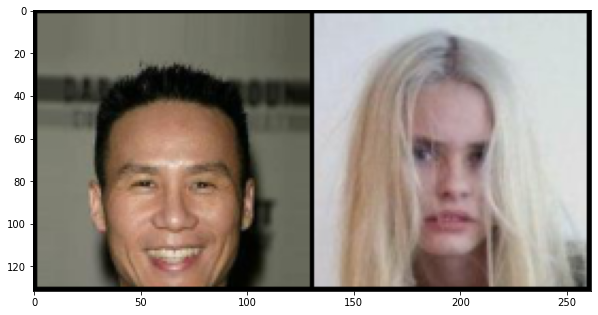

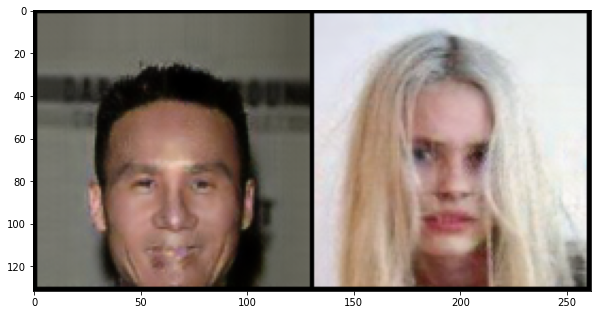

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            disc_B_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")

            ### Save to Google Drive ###
            if epoch % save_epoch == 0:
              filename =  model_name + '_' + str(epoch)
              save_model_to_drive(filename, model_dir)

            cur_step += 1

train(save_model=True)

## Save final model weights

In [ ]:
next_filename = int(model_name[-1]) + 1
save_model_to_drive(next_filename, model_dir)

In [ ]:
save_filename = '/content/drive/MyDrive/CycleGAN/models/' + 'smile_final'
torch.save({
  'gen_AB': gen_AB.state_dict(),
  'gen_BA': gen_BA.state_dict(),
  'gen_opt': gen_opt.state_dict(),
  'disc_A': disc_A.state_dict(),
  'disc_A_opt': disc_A_opt.state_dict(),
  'disc_B': disc_B.state_dict(),
  'disc_B_opt': disc_B_opt.state_dict()
}, f"{save_filename}.pth")

# Testing